In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
data=np.load("data.npz")
traindata_x,traindata_y,testdata_x,testdata_y=data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']
print(traindata_x.shape,traindata_y.shape,testdata_x.shape,testdata_y.shape)
print(traindata_x.dtype,traindata_y.dtype,testdata_x.dtype,testdata_y.dtype)

(10580, 52) (10580,) (21120, 52) (21120,)
float64 int32 float64 int32


In [3]:
#求正常样本的均值和方差，并以此为基准对所有数据做标准化
normal_samples=np.vstack((traindata_x[:500,:],testdata_x[:960,:]))
normal_labels=np.hstack((traindata_y[:500],testdata_y[:960]))
print(np.unique(normal_labels))
print(normal_samples.shape)

mean=np.mean(normal_samples,axis=0)
print(mean.shape,mean)
std=np.std(normal_samples,axis=0)
print(std.shape,std)

#print('origan:',traindata_x[:2,:])
traindata_x2=(traindata_x-mean)/std
testdata_x2=(testdata_x-mean)/std
#print('processed',traindata_x2[:2,:])

[0]
(1460, 52)
(52,) [  2.50552740e-01   3.66219884e+03   4.51115521e+03   9.34419719e+00
   2.69040370e+01   4.23314048e+01   2.70557048e+03   7.50073514e+01
   1.20399925e+02   3.37109432e-01   8.00884740e+01   4.99755822e+01
   2.63433527e+03   2.51636007e+01   4.99697233e+01   3.10275315e+03
   2.29077425e+01   6.58077445e+01   2.32738164e+02   3.41440199e+02
   9.46041801e+01   7.72817096e+01   3.21870507e+01   8.89535233e+00
   2.63963192e+01   6.88255123e+00   1.87724342e+01   1.65560877e+00
   3.29736041e+01   1.38240178e+01   2.39995384e+01   1.25287038e+00
   1.85580863e+01   2.26288384e+00   4.83894397e+00   2.29874521e+00
   1.80560748e-02   8.35738596e-01   9.85035959e-02   5.36895445e+01
   4.38784726e+01   6.30245363e+01   5.39925514e+01   2.46546527e+01
   6.13084164e+01   2.22389240e+01   4.00393473e+01   3.80281699e+01
   4.64639486e+01   4.80833137e+01   4.10995260e+01   1.82237856e+01]
(52,) [  3.01024696e-02   3.38759323e+01   3.64990817e+01   7.86022638e-02
   2.0

0.896539415734
[0.89653941573413765, 24.029732369532045, 65.819791154487547, 1.0279565045668302, 1.8811579179352889, 5.5638191797437813, 478.61055229548663, 14.855833121677694, 24.954151674831035, 1.0470552227072289, 1.9436744498804699, 2.432950621360682, 19.844601105307884, 28.930534099448543, 10.352233514274204, 0.98578593486791088, 1.2289359310400234, 41.114714733961328, 279.33031494071997, 1.1556262698818276, 3.014172580556195, 1.0492646752970702]


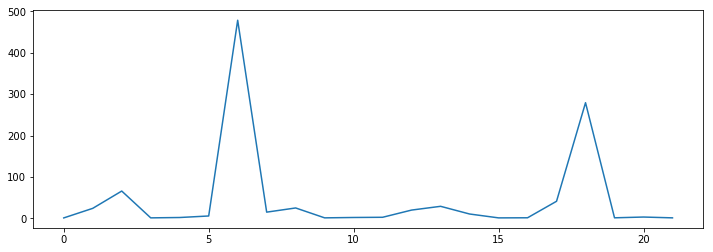

In [4]:
#求每个类别标准化后的norm2，故障和正常数据的norm2有较大差异
norm_0=np.mean(traindata_x2[:500,:]**2)
print(norm_0)
norm=[norm_0]
for i in range(1,22):
    norm_i=np.mean(traindata_x2[500+(i-1)*480:500+i*480,:]**2)
    norm.append(norm_i)
print(norm) 

%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12,4))
plt.plot(norm)
plt.show()

#！！！猜想：norm2大的类别对应的测试准确率要高一些，是否是正相关的？

In [5]:
#训练集中的故障数据前填充20个零向量，使得训练集为(22, 500, 52)

traindata_x_pad=[traindata_x2[:500,:]]
traindata_y_pad=[traindata_y[:500]]
for i in range(1,22):
    data_i=traindata_x2[500+(i-1)*480:500+i*480,:]
    #print(data_i.shape)
    data_i=np.vstack((np.zeros((20,52)),data_i))
    #print(i,data_i.shape)
    label_i=traindata_y[500+(i-1)*480:500+i*480]
    label_i=np.hstack((np.zeros(20,dtype=np.int32),label_i))
    
    traindata_x_pad.append(data_i)
    traindata_y_pad.append(label_i)

traindata_x_pad=np.array(traindata_x_pad)
traindata_y_pad=np.array(traindata_y_pad)
traindata_y_pad=traindata_y_pad.reshape(traindata_y_pad.shape[0],traindata_y_pad.shape[1],-1)
print(traindata_x_pad.shape,traindata_y_pad.shape)

dataset1=np.concatenate((traindata_x_pad,traindata_y_pad),axis=2)
print(dataset1.shape)

(22, 500, 52) (22, 500, 1)
(22, 500, 53)


In [6]:
#reshape测试集，使得训练集为(22, 960, 52)
print(testdata_x2.shape,testdata_y.shape)

testdata_x_pad=testdata_x2.reshape(22,-1,testdata_x2.shape[1])
testdata_y_pad=testdata_y.reshape(22,-1,1)
print(testdata_x_pad.shape,testdata_y_pad.shape)

dataset2=np.concatenate((testdata_x_pad,testdata_y_pad),axis=2)
print(dataset2.shape)

(21120, 52) (21120,)
(22, 960, 52) (22, 960, 1)
(22, 960, 53)


In [7]:
def create_dataset(dataset, look_back=100):
    dataX, dataY = [],[]
    for j in range(dataset.shape[0]):
        for i in range(dataset.shape[1]-look_back):
            a = dataset[j,i:(i + look_back),0:-1]
            dataX.append(a)
            dataY.append(dataset[j,i:(i + look_back),-1])
    
    return np.array(dataX), np.array(dataY,dtype=np.int32)


In [8]:
# 创建好输入输出
train_X, train_Y = create_dataset(dataset1)
test_X, test_Y = create_dataset(dataset2)
print(train_X.shape,train_Y.shape,train_X.dtype,train_Y.dtype)
print(test_X.shape,test_Y.shape,test_X.dtype,test_Y.dtype)

def onehot_encoder(y,cls=22):#y.shape=(n,l)
    
    y_hat=np.zeros((y.shape[0],y.shape[1],cls),dtype=np.int)
    print(y_hat.shape)
    for i in range(y.shape[0]):
        for j in range (y.shape[1]):
            index=int(y[i,j])
            #print(index)
            y_hat[i,j,index]=1
    return y_hat

#x=train_Y[(0,1000,5000),:]
#print(x)
#trainy_hat=onehot_encoder(x)
#print(trainy_hat)

(8800, 100, 52) (8800, 100) float64 int32
(18920, 100, 52) (18920, 100) float64 int32


In [9]:
data_all = np.concatenate((train_X,test_X),axis=0)
label_all = np.concatenate((train_Y,test_Y),axis=0)
print(data_all.shape,label_all.shape)

#重新划分训练集和测试集
from sklearn.cross_validation import train_test_split
train_X,test_X,train_Y,test_Y=train_test_split(data_all, label_all, test_size=0.2, random_state=42) 
print(train_X.shape,test_X.shape,train_Y.shape,test_Y.shape)


(27720, 100, 52) (27720, 100)


/home/zqq/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(22176, 100, 52) (5544, 100, 52) (22176, 100) (5544, 100)


In [10]:
#转换成Tensor
train_x = (torch.from_numpy(train_X)).float()
train_y = torch.from_numpy(train_Y).long()
test_x = (torch.from_numpy(test_X)).float()
test_y = torch.from_numpy(test_Y).long()
print(train_x.dtype,train_x.size())
print(test_x.dtype,test_x.size())
print(train_y.dtype,train_y.size())
print(test_y.dtype,test_y.size())

torch.float32 torch.Size([22176, 100, 52])
torch.float32 torch.Size([5544, 100, 52])
torch.int64 torch.Size([22176, 100])
torch.int64 torch.Size([5544, 100])


In [11]:
# 先转换成 torch 能识别的 Dataset
import torch.utils.data as Data

train_dataset = Data.TensorDataset(train_x,train_y)
# 把 dataset 放入 DataLoader
train_loader = Data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=64,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)
test_dataset = Data.TensorDataset(test_x,test_y)
# 把 dataset 放入 DataLoader
test_loader = Data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=64,      # mini batch size
    #shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

#定义模型
class lstm(nn.Module):
    def __init__(self, input_size=52, hidden_size=100, output_size=22, num_layers=3, batch_first=True, device=device):            
          super(lstm, self).__init__()
          self.input_size=input_size
          self.hidden_size=hidden_size
          self.output_size=output_size
          self.num_layers=num_layers
          self.batch_first=batch_first
          self.device=device
        
          self.dropout = nn.Dropout(p=0.2)  #1/(1-p)
          self.rnn = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=self.batch_first)
          self.reg = nn.Linear(self.hidden_size, self.output_size)

    def init_weights(self, initrange=0.2):
        """Initialize weights."""
        for weight in self.rnn.parameters():
            weight.data.uniform_(-initrange, initrange)
        self.reg.weight.data.uniform_(-initrange, initrange)
        self.reg.bias.data.uniform_(-initrange, initrange)
        
    def init_hidden(self, input):
        minibatch_size = input.size(0) \
                if self.batch_first else input.size(1)
        h0 = torch.zeros(self.num_layers, minibatch_size, self.hidden_size, device=self.device)
        c0 = torch.zeros(self.num_layers, minibatch_size, self.hidden_size, device=self.device)
        return (h0, c0) 
    
    def forward(self, x):
         h0_c0 = self.init_hidden(x)
         out,ht_ct = self.rnn(self.dropout(x),None) 
         b, l, h = out.shape  #(batch, seq, hidden)
         #print(out.shape)
         out = out.contiguous().view(l*b, h) #转化为线性层的输入方式
         y = self.reg(self.dropout(out))
         #y = y.view(b, l, -1)        
         return y  
    
    def load_model(self, load_dir):
        if self.device.type == 'cuda':
            self.load_state_dict(torch.load(open(load_dir, 'rb')))
        else:
            self.load_state_dict(torch.load(open(load_dir, 'rb'), map_location=lambda storage, loc: storage))

    def save_model(self, save_dir):
        torch.save(self.state_dict(), open(save_dir, 'wb'))

    
net = lstm(device=device)
net.to(device)
'''
weight=torch.tensor([0.040153845166554944, 0.036382060580354744, 0.036219653713873694, 0.07578880042180282, 0.03661752326822607, 0.03787888800374739, 0.03614607125330093, 0.03612018654701804, 0.036784091527261545, 0.059546093073929995, 0.04380238498517394,
                     0.04286410139544747, 0.03880078879783693, 0.039248820284410964, 0.03688048020961498, 0.1082217246438273, 0.052223568477666946, 0.03733155618292655, 0.04264773962980153, 0.04291206161444662, 0.04511382570380278, 0.03831573451897396]
                    ,device=device)
print(weight.dtype,weight.device)
criterion = nn.CrossEntropyLoss(weight=weight)
'''
criterion = nn.CrossEntropyLoss()

#稀疏编码器加L1约束
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

cuda:0


In [13]:
def val_acc(net,test_loader):
    Losses=[]
    Acces=[] 
    Dets=[]
    #net.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(test_loader):
          #if step<3:
            batch_x=batch_x.to(device)
            batch_y=batch_y.to(device)
            out = net(batch_x)
            batch_y=batch_y.view(-1)
            loss = criterion(out,batch_y)
            total = batch_y.size(0)
            Losses.append(loss.item()/total)
            
            out=F.softmax(out,1)
            _,index=out.max(dim=1)
            #print(index.size(),index)
            #print('test_result:',np.unique(index.cpu().numpy()))
            
            acc=(index==batch_y).sum().cpu().numpy()       
            Acces.append(acc/total)
            det=((index>0)==(batch_y>0)).sum().cpu().numpy()       
            Dets.append(det/total)
        #print(Losses,Acces)
    return np.mean(Losses),np.mean(Acces),np.mean(Dets)

#Loss,Acc=val_acc(net,test_loader)   
#print(Loss,Acc)

In [14]:
#开始训练
net.init_weights()
#net.to(device)
for e in range(20):
    Losses=[]
    Acces=[] 
    Dets=[]
    for step, (batch_x, batch_y) in enumerate(train_loader):
      #if step<300:  
        optimizer.zero_grad()
        batch_x=batch_x.to(device)
        batch_y=batch_y.to(device)
        #print('input:',batch_x.size(),batch_y.size())
        out = net(batch_x)
        #print('forward:',out.size(),batch_y.size())
        #out=out.view(-1,22)
        batch_y=batch_y.view(-1)
        #print('reshape:',out.size(),batch_y.size())
        loss = criterion(out,batch_y)
        
        #反向传播      
        loss.backward()
        #grandent clip
        #torch.nn.utils.clip_grad_value_(net.parameters(), 5)
        optimizer.step()
        
        total = batch_y.size(0)
        Losses.append(loss.item()/total)
        
        out=F.softmax(out,1)
        _,index=out.max(dim=1)
        #print(index.size(),index)
        #print('train_result:',np.unique(index.cpu().numpy()))
        
        acc=(index==batch_y).sum().cpu().numpy()       
        Acces.append(acc/total)
        det=((index>0)==(batch_y>0)).sum().cpu().numpy()       
        Dets.append(det/total)
    
    #print(Losses,Acces)        
    if e==0: print('Epoch:0, TrainLoss:{:.5f}, TrainAcc:{:.5f}, TrainDet:{:.5f},'.format(Losses[0],Acces[0],Dets[0]))
    print('Epoch:{}, TrainLoss:{:.5f}, TrainAcc:{:.5f}, TrainDet:{:.5f}'.format(e+1, np.mean(Losses),np.mean(Acces),np.mean(Dets)))
    if (e+1)%10==0:
          Loss,Acc,Det=val_acc(net,test_loader)
          print('  Val Epoch:{}, TestLoss:{:.5f}, TestAcc:{:.5f}, TestDet:{:.5f},'.format(e+1, np.mean(Loss),np.mean(Acc),np.mean(Det)))


Epoch:0, TrainLoss:0.00049, TrainAcc:0.01937, TrainDet:0.85953,
Epoch:1, TrainLoss:0.00010, TrainAcc:0.80303, TrainDet:0.88894
Epoch:2, TrainLoss:0.00002, TrainAcc:0.95714, TrainDet:0.97967
Epoch:3, TrainLoss:0.00001, TrainAcc:0.97436, TrainDet:0.98729
Epoch:4, TrainLoss:0.00001, TrainAcc:0.98058, TrainDet:0.99030
Epoch:5, TrainLoss:0.00001, TrainAcc:0.97985, TrainDet:0.99049
Epoch:6, TrainLoss:0.00001, TrainAcc:0.97980, TrainDet:0.99024
Epoch:7, TrainLoss:0.00001, TrainAcc:0.98447, TrainDet:0.99236
Epoch:8, TrainLoss:0.00001, TrainAcc:0.98309, TrainDet:0.99205
Epoch:9, TrainLoss:0.00001, TrainAcc:0.97384, TrainDet:0.98746
Epoch:10, TrainLoss:0.00001, TrainAcc:0.98066, TrainDet:0.99047
  Val Epoch:10, TestLoss:0.00001, TestAcc:0.98354, TestDet:0.99157,
Epoch:11, TrainLoss:0.00001, TrainAcc:0.98515, TrainDet:0.99252
Epoch:12, TrainLoss:0.00001, TrainAcc:0.98490, TrainDet:0.99213
Epoch:13, TrainLoss:0.00001, TrainAcc:0.98641, TrainDet:0.99310
Epoch:14, TrainLoss:0.00001, TrainAcc:0.98586

In [15]:
net.save_model("LSTM3_L100_epoch20.pth")

In [ ]:
net.load_model("LSTM3_L10_epoch200.pth")

********************************************************************
(204,)
********************************************************************
********************************************************************
(131,)
********************************************************************
********************************************************************
(7,)
********************************************************************
********************************************************************
(490,)
********************************************************************
********************************************************************
(779,)
********************************************************************
********************************************************************
(299,)
********************************************************************
********************************************************************
(197,)
********************************************************

********************************************************************
(283,)
********************************************************************
********************************************************************
(393,)
********************************************************************
********************************************************************
(94,)
********************************************************************
********************************************************************
(131,)
********************************************************************
********************************************************************
(486,)
********************************************************************
********************************************************************
(299,)
********************************************************************
********************************************************************
(194,)
*******************************************************

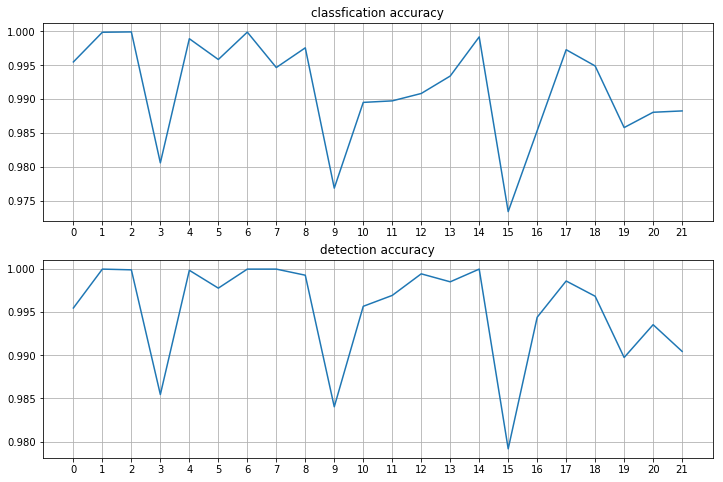

In [16]:
#batch_size=64
look_back=100
#训练完成之后，我们可以用训练好的模型去预测后面的结果
def jude(x):
    if x in (3,9,15):return True
    else: return False

Acc=[0]*22 
Det=[0]*22
Total=[0]*22
net = net.eval()
with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(test_loader):
        batch_x=batch_x.to(device)
        batch_y=batch_y.to(device)
        out = net(batch_x)
        batch_y=batch_y.view(-1)
        out=F.softmax(out,1)
        _,index=out.max(dim=1)
        
       # print('test_result:',np.unique(index.cpu().numpy()))
        index=index.cpu().numpy()
        #输出3，9，15的预测值和真实值
        ind=index.reshape(-1,look_back)
        #print(ind.shape)
        row=np.where(ind==15)[0] 
        print("********************************************************************")
        print(row.shape)
        #print("row=",row)
        #for i in row:
           # if (ind[i,:]!=batch_y.reshape(-1,look_back)[i,:]).any():
               # print(ind[i,:],batch_y.reshape(-1,look_back)[i,:])
        #print(ind.shape,ind[row,:])
        batch_y=batch_y.cpu().numpy()
        print("********************************************************************")
        #按类别统计正确率
        for i in range(batch_y.shape[0]):
            Total[batch_y[i]]+=1
            if index[i]==batch_y[i]:
                Acc[batch_y[i]]+=1
            if (index[i]>0)==(batch_y[i]>0):
                Det[batch_y[i]]+=1
                
for i in range(22):
    Acc[i]/=Total[i]
    Det[i]/=Total[i]

#print(sum(Total)/6,Total)
print(Acc)
print(Det)

fig = plt.figure(figsize=(12,8))
#fig.subsubplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8，hspace=0.2, wspace=0.3)
sub1=plt.subplot(2,1,1)
sub2=plt.subplot(2,1,2)

sub1.plot(Acc)
sub1.set_title(u'classfication accuracy')
sub1.set_xticks(range(22))
sub1.grid(True)
sub2.plot(Det)
sub2.set_title(u'detection accuracy')
sub2.set_xticks(range(22))
sub2.grid(True)
plt.show()


In [1]:
import numpy as np
Acc1=np.array([0.9948960589298277, 0.9997762062483215, 0.9998750988800533, 0.9787325088792845, 0.9990940387751405,
               0.996909355821449, 1.0, 0.9989421882904843, 0.9900534901198002, 0.9820989143546441, 0.987306773909765,
               0.990609657276324, 0.9932675747612337, 0.9938020110957004, 0.998448543354594, 0.9714311668256347,
               0.9860397361712459, 0.9979317476732161, 0.990303648890023, 0.9907189754397341, 0.983900198086568,
               0.9908818920074085])
Det1=np.array([0.9948960589298277, 1.0, 0.9998750988800533, 0.9846805597158629, 0.999909403877514, 0.9983222217316438, 
               1.0, 0.9998620245596284, 0.9991158657884267, 0.9863932448733413, 0.9945540614134305, 0.9968063301396635,
               0.9995694379207766, 0.9965325936199723, 1.0, 0.9789253758459372, 0.9928377776878566, 0.9985719210124587,
               0.9965552436846135, 0.9924211720839751, 0.9886627049353057, 0.9923065963812508])
np.savez('Zclassfiction_acc_100.npz',Acc1)
np.savez('Zdetection_acc_100.npz',Det1)

In [22]:
#给不同类别加权
weights=[1/x for x in Acc]
SUM=sum(weights)
weights=[x/SUM for x in weights]
print(weights)

[0.04323830280572525, 0.04030276903792014, 0.04035819279291436, 0.05839888304397833, 0.04181520936717636, 0.04510520970958691, 0.04027649604636999, 0.04060872602644792, 0.041154457813048356, 0.05957389864061199, 0.04771688691905819, 0.046162414048971034, 0.04217796152495399, 0.04244523044886684, 0.04088411559879369, 0.05876532566003698, 0.04879973794829892, 0.041623823672120454, 0.04373707585107615, 0.047955796321033896, 0.046620291978201854, 0.042279194744808284]
